# Welcome to the Prognostics Model Library Tutorial

The goal of this notebook is to instruct the user on how to use and extend the NASA Python Prognostics Model Package. 

First some background. The Prognostics Model Package is a python package for modeling and simulation of the evolution of state physical components, with a focus on simulating specific events. When used for prognostics, these events are typically system failures, such as a winding failure on a motor or full discharge of a battery. 

A few definitions:
* events: some state that can be predicted (e.g., system failure). An event has either occured or not. 
* event state: progress towards event occuring. Defined as a number where an event state of 0 indicates the event has occured and 1 indicates no progress towards the event (i.e., fully healthy operation for a failure event). For gradually occuring events (e.g., discharge) the number will progress from 1 to 0 as the event nears.
* inputs: control applied to the system being modeled (e.g., current drawn from a battery)
* outputs: measured sensor values from a system (e.g., voltage and temperature of a battery)
* states: Internal parameters used to represent the state of the system- can be same as inputs/outputs but do not have to be. 
* process noise: Uncertainty in the model transition. 
* measurement noise: Uncertainty in the sensors and actualy measurement of outputs

The `prog_models` package has the following structure
* `prog_models/prognostics_model` - parent class for all prognostics models - defines interfaces that a model must implement, and tools for simulating said model 
* `prog_models/models` - implemented models (e.g., pump, valve, battery)
* `prog_models/visualize` - tools for visualizing the results of a simulation 

In addition to the `prog_models` package, this repo includes examples showing how to use the package (see `examples/`), a template for implementing a new model (`prog_model_template`), documentation (`docs/`), and this tutorial (`tutorial.ipynb`).

Now lets get started with some examples

## Using the included models

First thing to do is to import the model you would like to use:

In [1]:
from prog_models.models import battery_circuit

This imports the battery_circuit model distributed with the `prog_models` package. 

Next, lets create a new battery using the default settings:

In [2]:
batt = battery_circuit.BatteryCircuit()

This creates a battery circuit model. You can also pass configuration parameters into the constructor as a dict to configure the system (e.g., `BatteryCircuit({'process_noise': 0})).

Alternatively, you can set the configuration of the system afterwards, like so:

In [3]:
batt.set_config('process_noise', 0) # No process noise

Lets use the member functions to check out some details of the model, first the model configuration:

In [4]:
print('configuration: ', batt.parameters)

configuration:  {'V0': 4.183, 'Rp': 10000.0, 'qMax': 7856.3254, 'CMax': 7777, 'VEOD': 3.0, 'Cb0': 1878.155726, 'Cbp0': -230, 'Cbp1': 1.2, 'Cbp2': 2079.9, 'Cbp3': 27.055726, 'Rs': 0.0538926, 'Cs': 234.387, 'Rcp0': 0.0697776, 'Rcp1': 1.50528e-17, 'Rcp2': 37.223, 'Ccp': 14.8223, 'Ta': 18.95, 'Jt': 800, 'ha': 0.5, 'hcp': 19, 'hcs': 1, 'x0': {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0, 'qcs': 0}, 'process_noise': {'tb': 0, 'qb': 0, 'qcp': 0, 'qcs': 0}, 'measurement_noise': {'t': 0.0, 'v': 0.0}}


Next the expected inputs (loading) and outputs (measurements)

In [5]:
print('inputs: ', batt.inputs)
print('outputs: ', batt.outputs)

inputs:  ['i']
outputs:  ['t', 'v']


Not lets look at what event we're predicting. This model only predicts one event, but that's not true for every model

In [6]:
print('event(s): ', batt.events)

event(s):  ['EOD']


Finally, let's take a look at the internal states that the model uses to represent the system:

In [7]:
print('states: ', batt.states)

states:  ['tb', 'qb', 'qcp', 'qcs']


Next, we define future loading. This is a function that describes how the system will be loaded as a function of time. Here we're defining a basic peasewise function.

In [8]:
def future_loading(t):
    # Variable (piece-wise) future loading scheme 
    if (t < 600):
        i = 2
    elif (t < 900):
        i = 1
    elif (t < 1800):
        i = 4
    elif (t < 3000):
        i = 2
    else:
        i = 3
    return {'i': i}

At last it's time to simulate. First we're going to simulate forward 200 seconds. To do this we have to define our first expected output (e.g., measurement) to initialize the model state. Then we're goign to use the function simulate_to() to simulate to the specified time and print the results

In [9]:
first_output = {'t': 18.95, 'v': 4.183} # temperature of 18.95, and voltage of 4.183
(times, inputs, states, outputs, event_states) = batt.simulate_to(200, future_loading, first_output)

for i in range(len(times)): # Print Results
    print("Time: {}\n\tInput: {}\n\tState: {}\n\tOutput: {}\n\tEvent State: {}\n".format(times[i], inputs[i], states[i], outputs[i], event_states[i]))

Time: 0
	Input: {'i': 2}
	State: {'tb': 18.95, 'qb': 7856.3254, 'qcp': 0, 'qcs': 0}
	Output: {'t': 18.95, 'v': 4.182999999010731}
	Event State: {'EOD': 1.0}

Time: 10
	Input: {'i': 2}
	State: {'tb': 19.009392328808794, 'qb': 7836.321374670183, 'qcp': 2.06894116298379, 'qcs': 14.192228589474794}
	Output: {'t': 19.009392328808794, 'v': 3.9801969126891716}
	Event State: {'EOD': 0.997427796665833}

Time: 20
	Input: {'i': 2}
	State: {'tb': 19.076442043154504, 'qb': 7816.317409400196, 'qcp': 2.0689378979001236, 'qcs': 20.413263009931665}
	Output: {'t': 19.076442043154504, 'v': 3.9509958120257234}
	Event State: {'EOD': 0.9948556010544164}

Time: 30
	Input: {'i': 2}
	State: {'tb': 19.14379089846118, 'qb': 7796.313465615618, 'qcp': 2.068936313161104, 'qcs': 23.140198876826624}
	Output: {'t': 19.14379089846118, 'v': 3.936712024138122}
	Event State: {'EOD': 0.9922834082056858}

Time: 40
	Input: {'i': 2}
	State: {'tb': 19.21108882800633, 'qb': 7776.309532730197, 'qcp': 2.0689354655665255, 'qcs': 2

We can also use the visualize package to plot the results

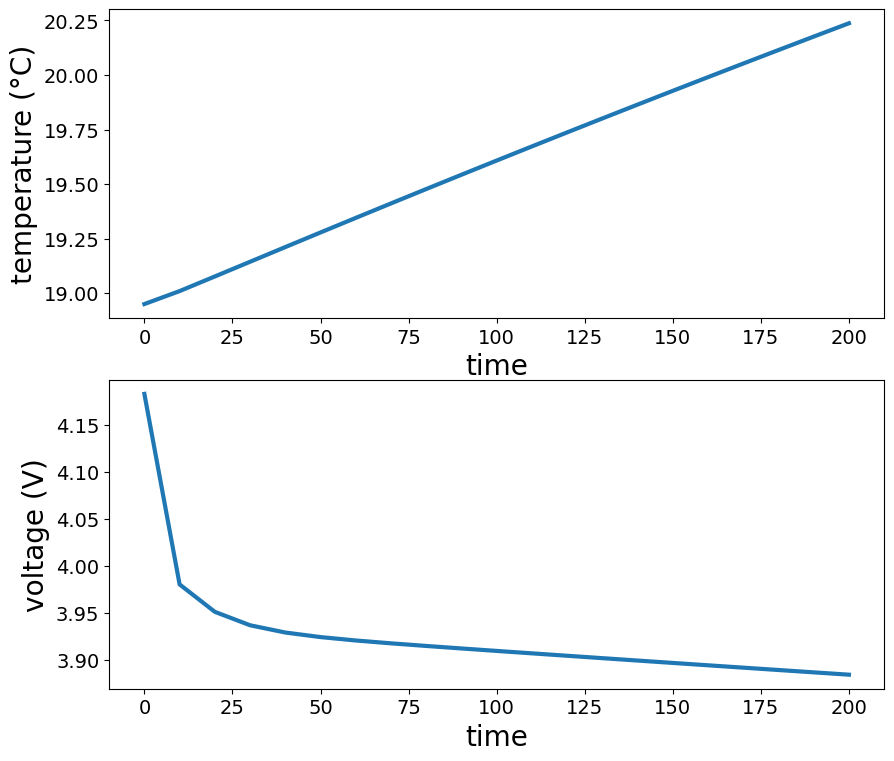

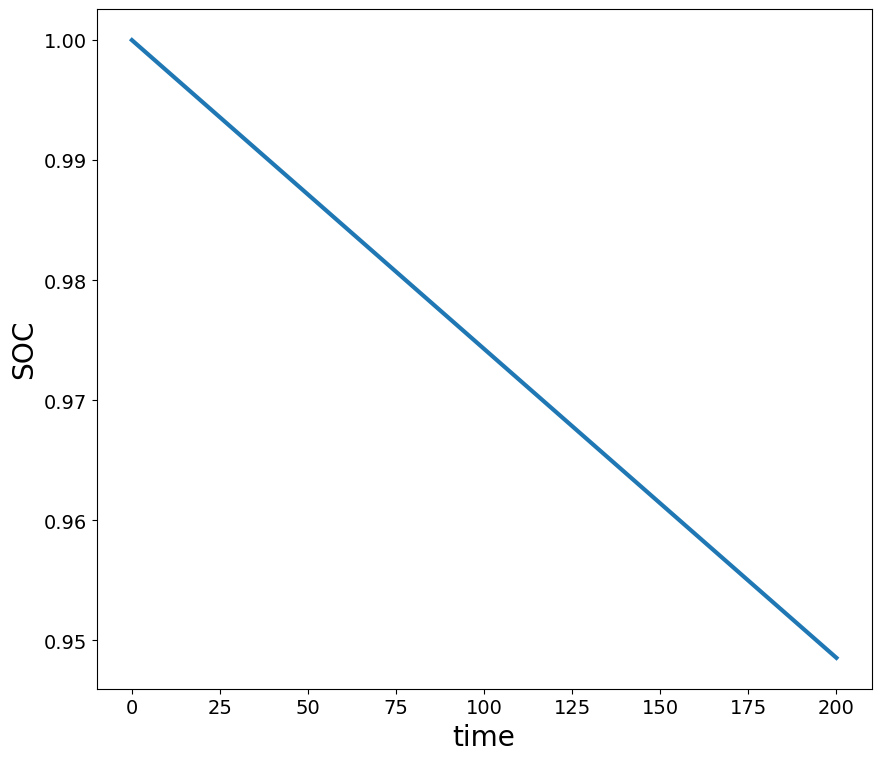

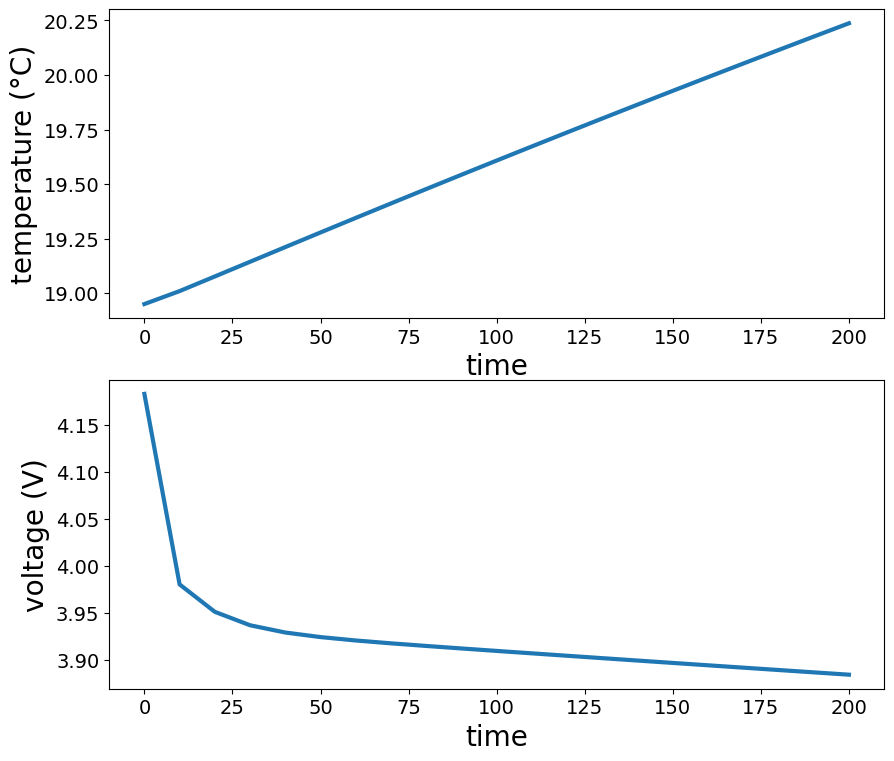

In [10]:
from prog_models import visualize
visualize.plot_timeseries( times, event_states, options={'ylabel': 'SOC'})
visualize.plot_timeseries( times, outputs, options={'ylabel': {'v': "voltage (V)", 't': 'temperature (°C)'}, 'compact': False})


Instead of specifying a specific amount of time, we can also simulate until a threshold has been met using the simulate_to_threshold() method




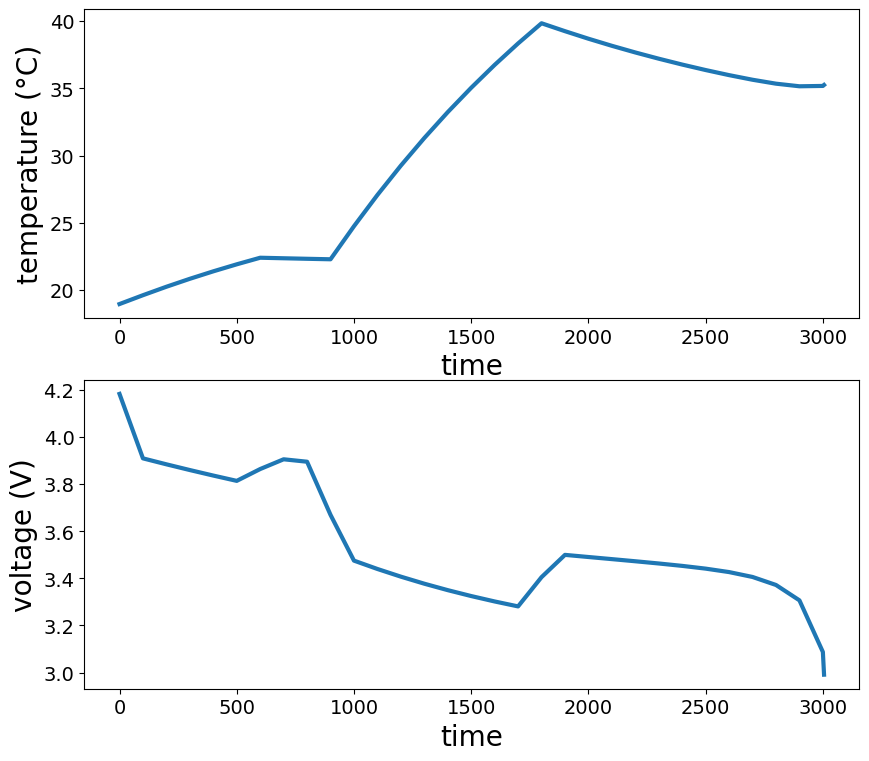

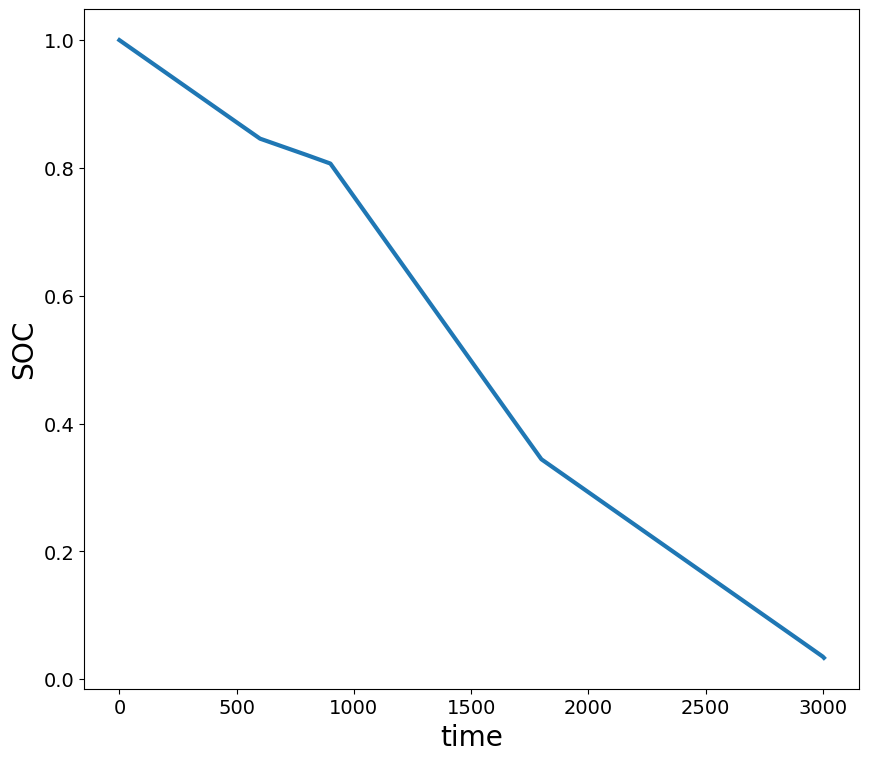

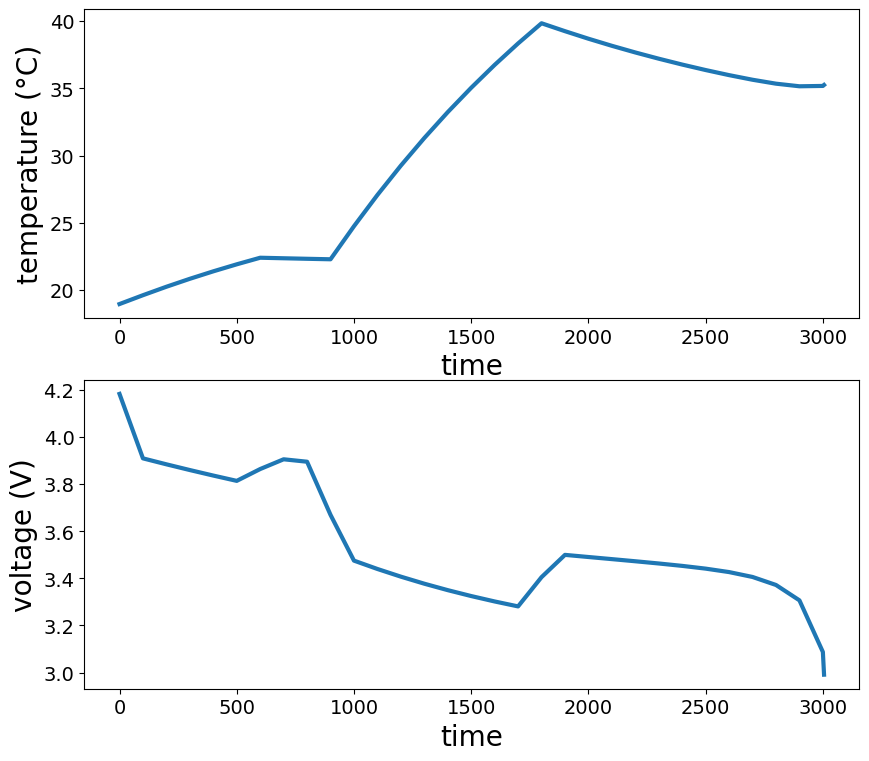

In [11]:
options = {'save_freq': 100}
(times, inputs, states, outputs, event_states) = batt.simulate_to_threshold(future_loading, {'t': 18.95, 'v': 4.183}, options)
visualize.plot_timeseries( times, event_states, options={'ylabel': 'SOC'})
visualize.plot_timeseries( times, outputs, options={'ylabel': {'v': "voltage (V)", 't': 'temperature (°C)'}, 'compact': False})

Default is to simulate until any threshold is met, but we can also specify which event we are simulating to (any key from model.events) for multiple event models. 

## Building a new model using model generation
The easiest way to build a new model is by using the model generation feature. This works for simple models.

For this example, let's use a model of throwing an object directly into the air in a vacuum.

First lets describe the model in a dictionary:

In [12]:
keys = {
    'inputs': [], # no inputs, no way to control
    'states': [
        'x', # Position (m) 
        'v'  # Velocity (m/s)
    ],
    'outputs': [ # Anything we can measure
        'x' # Position (m)
    ],
    'events': [
        'falling', # Event- object is falling
        'impact' # Event- object has impacted ground
    ]
}

Here we have a description of what we're going to try to model, including any inputs, states, outputs, and predicted events. Now we can start defining the details of the model logic.

First, we're going to define the initialization function. This is used to generate the first state.

In [13]:
thrower_height = 1.83 # m
throwing_speed = 40 # m/s
def initialize(u, z):
    return {
        'x': thrower_height, # Thrown, so initial altitude is height of thrower
        'v': throwing_speed # Velocity at which the ball is thrown - this guy is an professional baseball pitcher
        }

Next, lets define the output equation- this translates from the state to any measurable parameters. In this case it's simple since we're saying the position ('x') state is directly measureable.

In [14]:
def output(t, x):
    return {
        'x': x['x']
    }

Now, let's define the threshold_met and event_state equations. This defines when each event has occured, and how close you are to the event occuring, respectively. 

In [15]:
def threshold_met(t, x):
    return {
        'falling': x['v'] < 0,
        'impact': x['x'] <= 0
    }

def event_state(t, x): 
    event_state.max_x = max(event_state.max_x, x['x']) # Maximum altitude
    return {
        'falling': max(x['v']/throwing_speed,0), # Throwing speed is max speed
        'impact': (x['v'] > 0) or max(x['x']/event_state.max_x,0) # 1 until falling begins, then it's fraction of height
    }
    event_state.max_x = 0
event_state.max_x = 0

Note: strictly speaking the threshold_met equation isn't needed here- the default behavior is that the threshold is met when event state reaches 0. We define it here, because this implementation is more efficient. 

Finally, we define the meat of the model. There are two types of models: continuous and discrete. Discrete models are defined by some sort of transition equation x' = next_state(t, x, u, dt) while continuous models can be defined by the first derivative dx = dx(t, x, u). This model is continuous, so we define the equation dx:

In [16]:
def dx(t, x, u):
    return {
        'x': x['v'],
        'v': -9.81 # Acceleration of gravity
    }

Now we have all our pieces and can put it all together

In [17]:
from prog_models.prognostics_model import PrognosticsModel
m = PrognosticsModel.generate_model(keys, initialize, output, event_state_eqn = event_state, threshold_eqn=threshold_met, dx_eqn=dx)

Now that we have our model `m` we can use it just like the model in our previous example. 

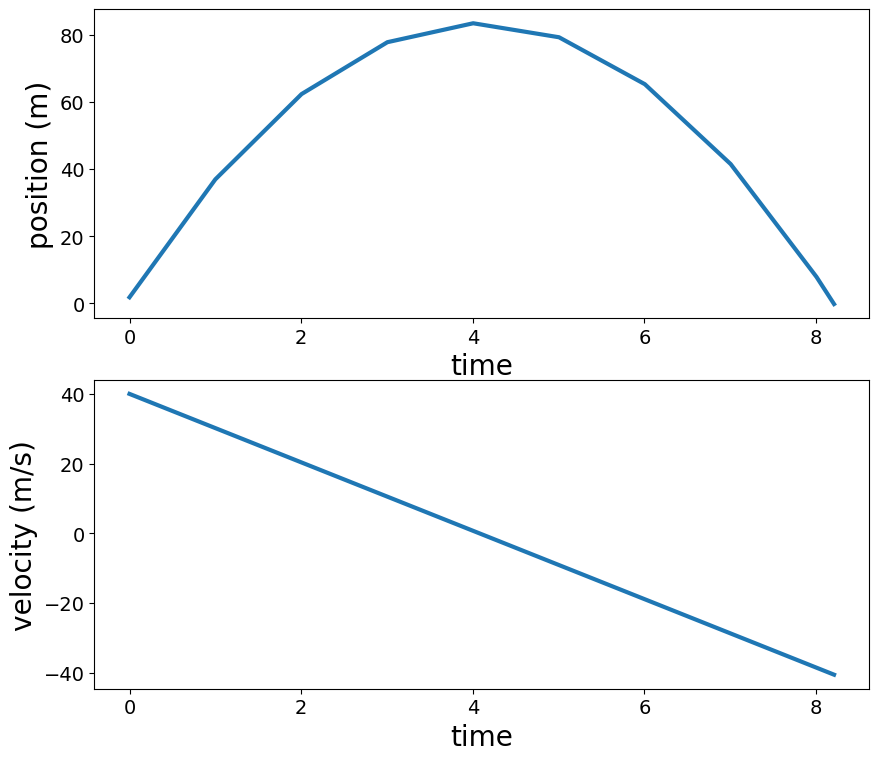

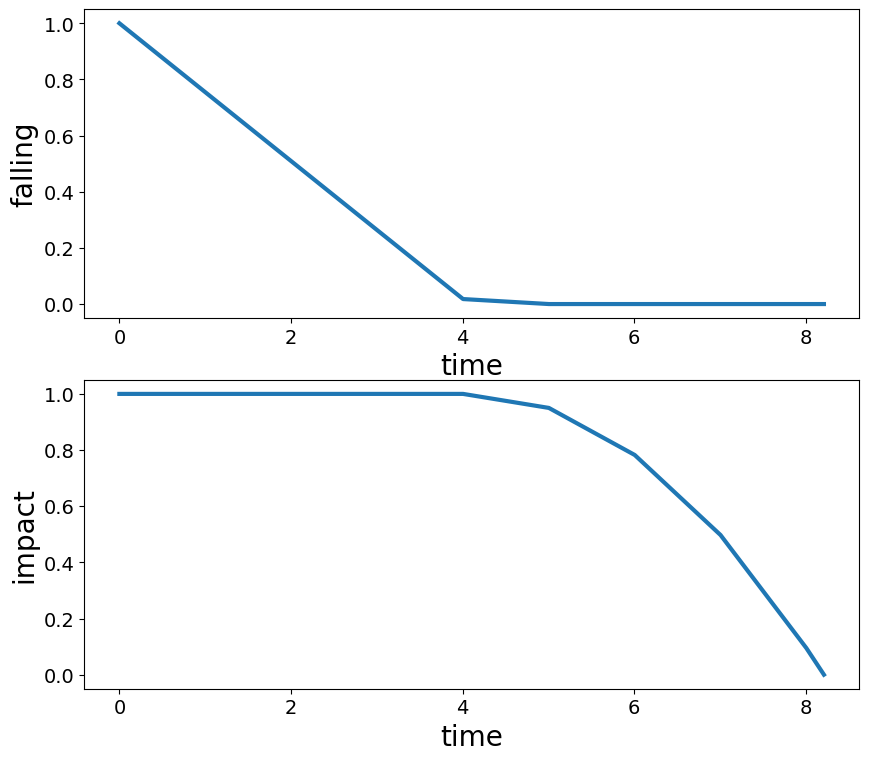

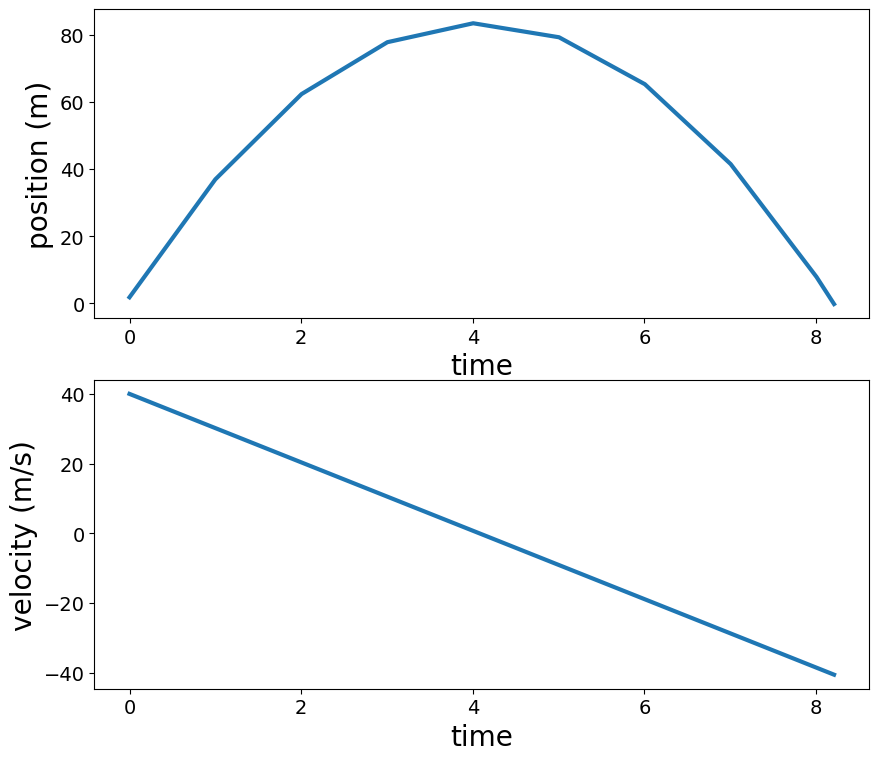

In [18]:
def future_load(t):
        return {} # No loading
event = 'impact'

(times, inputs, states, outputs, event_states) = m.simulate_to_threshold(future_load, {'x':thrower_height}, threshold_keys=[event], options={'dt':0.005, 'save_freq':1})

visualize.plot_timeseries( times, event_states, options={'ylabel': ['falling', 'impact'], 'compact': False})
visualize.plot_timeseries( times, states, options={'ylabel': {'x': "position (m)", 'v': 'velocity (m/s)'}, 'compact': False})

## Building a new model - advanced
For more advanced models, you can create a seperate class to defin the logic of the model. The functions are the same, just in a different format, and with added parameters. The model above could be defined using this approach like so:


In [19]:
from prog_models.prognostics_model import PrognosticsModel

# Model used in example
class ThrownObject(PrognosticsModel):
    """
    Model that similates an object thrown into the air without air resistance
    """

    inputs = [] # no inputs, no way to control
    states = [
        'x', # Position (m) 
        'v'  # Velocity (m/s)
        ]
    outputs = [ # Anything we can measure
        'x' # Position (m)
    ]
    events = [
        'falling', # Event- object is falling
        'impact' # Event- object has impacted ground
    ]

    # The Default parameters. Overwritten by passing parameters dictionary into constructor
    default_parameters = {
        'thrower_height': 1.83, # m
        'throwing_speed': 40, # m/s
        'g': -9.81, # Acceleration due to gravity in m/s^2
        'process_noise': 0.0 # amount of noise in each step
    }

    def initialize(self, u, z):
        self.max_x = 0.0
        return {
            'x': self.parameters['thrower_height'], # Thrown, so initial altitude is height of thrower
            'v': self.parameters['throwing_speed'] # Velocity at which the ball is thrown - this guy is an professional baseball pitcher
            }
    
    def dx(self, t, x, u):
        # apply_process_noise is used to add process noise to each step
        return self.apply_process_noise({
            'x': x['v'],
            'v': self.parameters['g'] # Acceleration of gravity
        })

    def output(self, t, x):
        return self.apply_measurement_noise({
            'x': x['x']
        })

    # This is actually optional. Leaving thresholds_met empty will use the event state to define thresholds.
    #  Threshold = Event State == 0. However, this implementation is more efficient, so we included it
    def threshold_met(self, t, x):
        return {
            'falling': x['v'] < 0,
            'impact': x['x'] <= 0
        }

    def event_state(self, t, x): 
        self.max_x = max(self.max_x, x['x']) # Maximum altitude
        return {
            'falling': max(x['v']/self.parameters['throwing_speed'],0), # Throwing speed is max speed
            'impact': (x['v'] > 0) or max(x['x']/self.max_x,0) # 1 until falling begins, then it's fraction of height
        }

Now the model can be generated and used like any of the other provided models

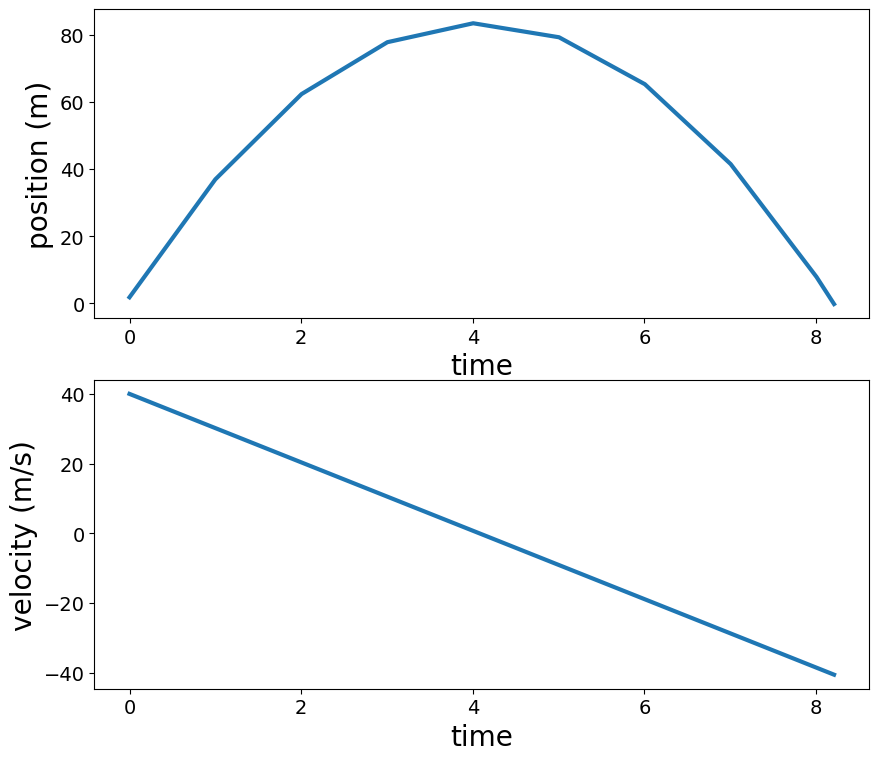

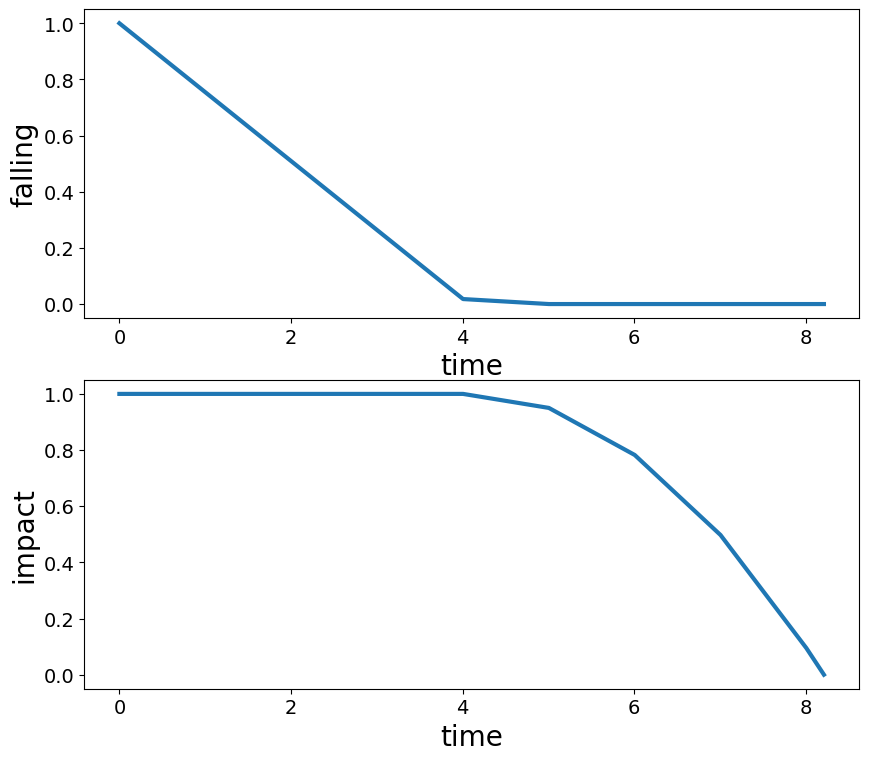

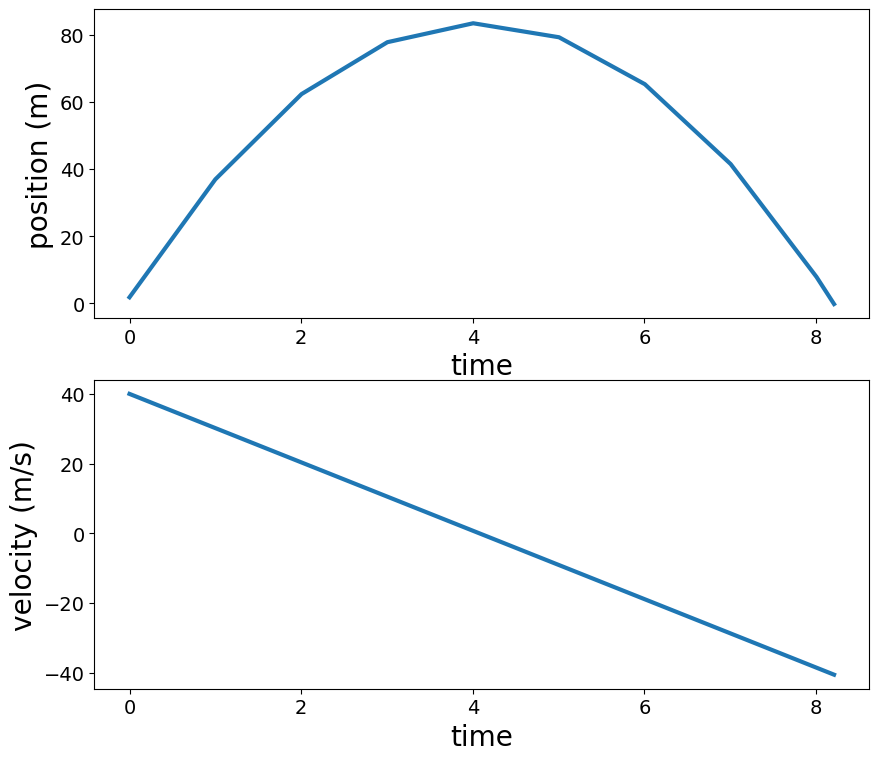

In [20]:
m = ThrownObject()

def future_load(t):
        return {} # No loading
event = 'impact'

(times, inputs, states, outputs, event_states) = m.simulate_to_threshold(future_load, {'x':m.parameters['thrower_height']}, threshold_keys=[event], options={'dt':0.005, 'save_freq':1})

from prog_models import visualize
visualize.plot_timeseries( times, event_states, options={'ylabel': ['falling', 'impact'], 'compact': False})
visualize.plot_timeseries( times, states, options={'ylabel': {'x': "position (m)", 'v': 'velocity (m/s)'}, 'compact': False})

## Conclusion
Thank you for trying out this tutorial. See the examples in the `examples/` folder for more details on how to use the package. Any questions can be directed to Chris Teubert (christopher.a.teubert@nasa.gov)